# Logisitic Regressor - Comparing improvment in College respect to High School times

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV

In [2]:
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')

In [3]:
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'

In [4]:
df.head(5)

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,...,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points,isHS
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330,True
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689,True
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878,True
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213,True
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879,True


In [5]:
df.dtypes

Event                category
Conf_Rank               int64
Time           string[python]
Name           string[python]
School         string[python]
Standard             category
Date           datetime64[ns]
Gender               category
Division             category
Season               category
SeasonYear              int64
Time_Adj      timedelta64[ns]
Time_Sec              float64
Div_Rank                int64
NCAA_Rank               int64
ID                      int64
Power_Tot             float64
Power                 float64
Record                float64
Points                float64
isHS                     bool
dtype: object

In [6]:
df['School'] = df['School'].astype('category')

In [7]:
# Create the aggregated pivot table
grouped = pd.pivot_table(df, 
                         index=['ID', 'Event'], 
                         columns='isHS', 
                         values='Points', 
                         aggfunc='max').reset_index()

/tmp/ipykernel_2918936/2376042558.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped = pd.pivot_table(df,


In [8]:
# Rename the columns
grouped = grouped.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})

In [9]:
# Add the 'Difference' column
grouped['Difference'] = grouped['Best_College_Points'] - grouped['Best_HS_Points']

In [10]:
grouped = grouped.dropna()

In [11]:
merged = pd.merge(df[['ID', 'Event', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  grouped, 
                  on=['ID', 'Event'], 
                  how='left')

In [12]:
merged = merged.dropna(subset=['Difference'])


In [13]:
merged['Rating'] = pd.cut(merged['Difference'], [-1000, 20, 1000], labels = ['bad', 'good'])

In [14]:
merged['Rating'].value_counts()

Rating
good    105146
bad     100519
Name: count, dtype: int64

In [15]:
merged = merged.dropna()

In [22]:
X = merged[['Gender', 'Division', 'Season']]
y = merged['Rating']

In [23]:
X_n = X.select_dtypes(include = 'number')
X_c = X.select_dtypes(exclude = 'number')
X_n = (X_n-X_n.mean())/X_n.std()
X_c = pd.get_dummies(X_c)
X_preproc = pd.concat([X_n, X_c], axis = 1)
X_preproc

,Gender_F,Gender_M,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
0,False,True,True,False,False,False,True,False,False,False,False,False
1,False,True,True,False,False,False,True,False,False,False,False,False
2,False,True,True,False,False,False,True,False,False,False,False,False
3,False,True,True,False,False,False,True,False,False,False,False,False
4,False,True,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
354314,True,False,False,False,False,True,False,False,False,False,False,True
354315,True,False,False,False,False,True,False,False,False,False,False,True
354318,True,False,False,False,False,True,False,False,False,False,False,True
354319,True,False,False,False,False,True,False,False,False,False,False,True


In [29]:
X_preproc = X_preproc.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [30]:
lregCV = LogisticRegressionCV(Cs=100, n_jobs = -1)

In [31]:
lregCV.fit(X_preproc, y)

LogisticRegressionCV(Cs=100, n_jobs=-1)

In [32]:
lregCV.score(X_preproc, y)

0.579238081345878

In [33]:
coef = lregCV.coef_[0]
coef = pd.Series(coef, index = X_preproc.columns)
coef.sort_values(ascending=False)

Gender_M        0.234372
Division_II     0.073316
Division_I      0.073226
Season_23_24    0.059203
Season_22_23    0.050142
Season_20_21    0.044841
Season_21_22    0.008214
Division_III   -0.003649
Season_19_20   -0.019507
Gender_F       -0.236556
dtype: float64

<Axes: >

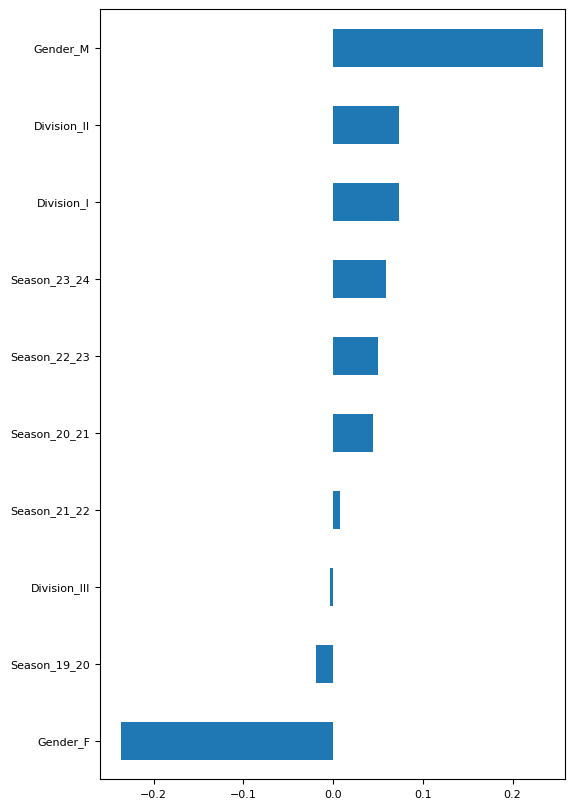

In [34]:
coef.sort_values(ascending=True).plot.barh(fontsize=8, figsize = (6, 10))

## L1 Logisitic Regressor

In [35]:
l1 = LogisticRegressionCV(Cs=100, n_jobs = -1, penalty = 'l1', solver = 'saga', max_iter = 1000)

In [36]:
l1.fit(X_preproc, y)

LogisticRegressionCV(Cs=100, max_iter=1000, n_jobs=-1, penalty='l1',
                     solver='saga')

In [37]:
l1.score(X_preproc, y)

0.579238081345878

In [38]:
coef = lregCV.coef_[0]
coef = pd.Series(coef, index = X_preproc.columns)
coef.sort_values(ascending=False)
coef

Gender_F       -0.236556
Gender_M        0.234372
Division_I      0.073226
Division_II     0.073316
Division_III   -0.003649
Season_19_20   -0.019507
Season_20_21    0.044841
Season_21_22    0.008214
Season_22_23    0.050142
Season_23_24    0.059203
dtype: float64

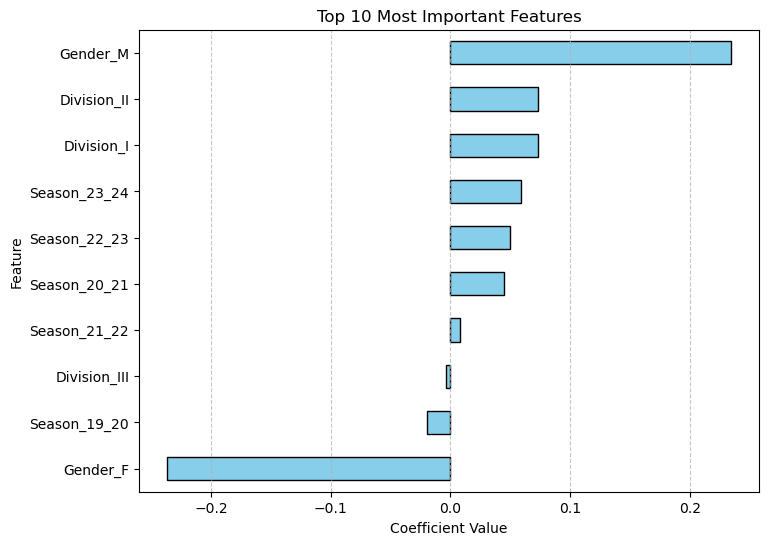

In [39]:
# Plot using pandas
coef.sort_values().plot.barh(color='skyblue', edgecolor='black', figsize=(8, 6))

# Labels and title
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()